In [15]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage,HumanMessage
from dotenv import load_dotenv
import operator

In [16]:
load_dotenv()

True

In [17]:
generator_llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
evaluator_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')
optimizer_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [18]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [19]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [20]:
# state
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved","needs_improvement"]
    feedback: str
    iteration: int
    max_iterations: int

    tweet_history: Annotated[list[str],operator.add]
    feedback_history: Annotated[list[str],operator.add]
    

In [21]:
def generate_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 50 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]


    response = generator_llm.invoke(messages).content

    return {'tweet':response,'tweet_history':[response]}


In [22]:
def evaluate_tweet(state: TweetState):

    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
        Evaluate the following tweet:

        Tweet: "{state['tweet']}"

        Use the criteria below to evaluate the tweet:

        1. Originality – Is this fresh, or have you seen it a hundred times before?  
        2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
        3. Punchiness – Is it short, sharp, and scroll-stopping?  
        4. Virality Potential – Would people retweet or share it?  
        5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

        Auto-reject if:
        - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
        - It exceeds 50 characters
        - It reads like a traditional setup-punchline joke
        - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

        ### Respond ONLY in structured format:
        - evaluation: "approved" or "needs_improvement"  
        - feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    
    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation,'feedback':response.feedback,'feedback_history':[response.feedback]}



In [23]:
def optimize_tweet(state: TweetState):

    messages = [
            SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
            HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    """)
        ]
     
    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response,'iteration': iteration,'tweet_history':[response]}


In [24]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return 'approved'
    else:
        return 'needs_improvement'

In [25]:
graph = StateGraph(TweetState)

# add node

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)


# add edges

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')


# loop
graph.add_conditional_edges('evaluate',route_evaluation,{'approved':END,'needs_improvement':'optimize'})
graph.add_edge('optimize','evaluate')

workflow = graph.compile()

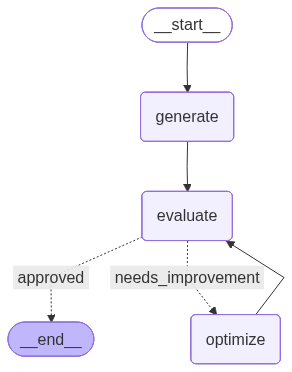

In [26]:
workflow

In [27]:
initial_state = {
    "topic": "erersfsadr3e",
    "iteration": 1,
    "max_iterations": 3
}
result = workflow.invoke(initial_state)

In [28]:
result

{'topic': 'erersfsadr3e',
 'tweet': 'My 87th password: erersfsadr3e. Nailed it.',
 'evaluation': 'approved',
 'feedback': 'This tweet is approved. It successfully taps into a universally relatable frustration with password creation, delivering a punchy and genuinely humorous observation. The concise format, combined with the absurd password example and the ironic "Nailed it," makes it highly shareable and effective. Its brevity ensures it is scroll-stopping, and the humor is derived from a common experience without relying on tired joke structures.',
 'iteration': 2,
 'max_iterations': 3,
 'tweet_history': ['My password after forgetting it for the 87th time: erersfsadr3e. Nailed it.',
  'My 87th password: erersfsadr3e. Nailed it.'],
 'feedback_history': ['This tweet effectively taps into a universally relatable experience, making it genuinely humorous and highly shareable due to its strong virality potential. The "Nailed it" punchline adds a clever, self-deprecating touch. However, the